In [41]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score
from torch.utils.data import TensorDataset, DataLoader, Dataset
from typing import Sequence, Tuple

from visualization import (
    plot_probability_heatmap, plot_learning_curves, plot_roc, plot_confusion,
    compare_grid, make_grid, model_prob_grid, save_animation
)


In [25]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')   # Check wether gpu is available

### The Mandelbrot set
The Mandelbrot set is a two-dimensional set that is defined in the complex plane as the complex numbers $c$ for which the function $f_c(z) = z^2 + c $ does not diverge to infinity when iterated starting at $z=0$.

Interesting properties:
- A point c belongs to the Mandelbrot set iff $|z| \leq 2$ for all $n \geq 0$


### Fourier Features

In [26]:
class FourierFeatures(nn.Module):
    """
        Gaussian Fourier Features
    """
    def __init__(self, in_dim=2, num_feats=256, sigma=10.0):
        super().__init__()
        B = torch.randn(in_dim, num_feats)
        self.register_buffer("B", B)

    def forward(self, x):
        proj = 2 * np.pi * x @ self.B
        return torch.cat([proj.sin(), proj.cos()], dim=-1)

### Creating a dataset

In [ ]:
def mandelbrot_grid_dataset(nx=750, ny=750, xlim=(-2.0, 1.0), ylim =(-1.5, 1.5), max_iter=1000):
    xs = np.linspace(xlim[0], xlim[1], nx)
    ys = np.linspace(ylim[0], ylim[1], ny)
    X, Y = np.meshgrid(xs, ys, indexing="xy")
    
    C = X + 1j * Y
    Z = np.zeros_like(C)
    mask = np.ones(C.shape, dtype=bool)

    for _ in range(max_iter):
        Z[mask] = Z[mask] * Z[mask] + C[mask]
        # Update mask for those that remain within radius 2
        mask[mask] = (np.abs(Z[mask]) <= 2.0)

    # If after max_iter still True, it's considered inside the set
    in_set = mask
    return X, Y, in_set

In [45]:
def escape_fraction(x, y, max_iter=200):
    """
    Returns a value in [0,1]:
      0   -> escaped immediately
      ~1  -> stayed bounded for many iterations / inside
    """
    c = complex(x, y)
    z = 0j
    for n in range(max_iter):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) > 4.0:
            return n / max_iter
    return 1.0


In [46]:
# def mandelbrot_labels(points, max_iter=1000):
#     """
#     points: (N, 2) array of (x, y)
#     returns: (N,) float32 in {0,1}
#     """
#     x = points[:, 0]
#     y = points[:, 1]
#     c = x + 1j * y
#     z = np.zeros_like(c, dtype=np.complex128)
#     mask = np.ones(c.shape, dtype=bool)

#     for _ in range(max_iter):
#         z[mask] = z[mask] * z[mask] + c[mask]
#         mask[mask] = (np.abs(z[mask]) <= 2.0)

#     return mask.astype(np.float32)


def build_multiscale_dataset(
    n_points=1000000,
    xlim=(-2.0, 1.0),
    ylim=(-1.5, 1.5),
    zoom_centers: Sequence[Tuple[float, float]] = (
        (-0.743643887037151, 0.131825904205330),  # seahorse valley
        (-0.7435669,          0.1314023),         # nearby spiral
    ),
    zoom_scale_range=(0.01, 1.0),  # fraction of full window size, log-uniform
    p_global=0.3,                  # probability of sampling from full domain
    max_iter=1000,
    random_state=42,
):
    """
    Returns:
        X: (N, 2) float32 array of coordinates
        y: (N,)  float32 array of labels in {0,1}
    """
    rng = np.random.default_rng(random_state)
    N = n_points

    full_width  = xlim[1] - xlim[0]
    full_height = ylim[1] - ylim[0]

    # Decide which samples are global vs zoomed
    is_global = rng.random(N) < p_global
    idx_global = np.where(is_global)[0]
    idx_zoom   = np.where(~is_global)[0]

    X = np.empty((N, 2), dtype=np.float32)

    #Global samples (uniform over whole domain)
    if len(idx_global) > 0:
        xs = rng.uniform(xlim[0], xlim[1], size=len(idx_global))
        ys = rng.uniform(ylim[0], ylim[1], size=len(idx_global))
        X[idx_global, 0] = xs
        X[idx_global, 1] = ys

    # Zoomed samples (multi-scale, multi-center)
    if len(idx_zoom) > 0:
        # pick a center for each zoom sample
        centers_idx = rng.integers(0, len(zoom_centers), size=len(idx_zoom))
        centers = np.array(zoom_centers)[centers_idx]  # (M, 2)

        # log-uniform scales in [zoom_scale_range[0], zoom_scale_range[1]]
        z_min, z_max = zoom_scale_range
        log_scales = rng.uniform(np.log10(z_min), np.log10(z_max), size=len(idx_zoom))
        scales = 10 ** log_scales  # (M,)

        widths  = full_width  * scales
        heights = full_height * scales

        # sample x,y uniformly in each random window
        xs = centers[:, 0] + (rng.random(len(idx_zoom)) - 0.5) * widths
        ys = centers[:, 1] + (rng.random(len(idx_zoom)) - 0.5) * heights

        X[idx_zoom, 0] = xs
        X[idx_zoom, 1] = ys
    
    print(f"Multiscale dataset: {N} points "
          f"({len(idx_global)} global, {len(idx_zoom)} zoomed)")
    # print("Positive ratio:", float(y.mean()))

    return X


In [47]:
class IndexedTensorDataset(Dataset):
    def __init__(self, X, y):
        # X: numpy (N,2), y: numpy (N,)
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], idx


### Neural Network

In [7]:
class NeuralNetFourierFeatures(nn.Module):
    def __init__(self, num_hidden_layers=3, num_feats=256, hidden_dim=32):
        super().__init__()
        self.ff = FourierFeatures(in_dim=2, num_feats=num_feats)

        layers = [
            nn.Linear(2*num_feats, hidden_dim),
            nn.ReLU(),
        ]

        for _ in range(num_hidden_layers):
            layers.append(
                nn.Linear(hidden_dim, hidden_dim)
            )
            layers.append(
                nn.ReLU()
            )

        # Output
        layers.append(
            nn.Linear(hidden_dim, 1)
        )
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = self.ff(x)
        x = self.network(x)
        return x

### Training Loop

In [8]:
from torch.utils.data import TensorDataset, DataLoader

def train(model, X_train, y_train, X_val, y_val, num_epoch=20, batch_size=16, lr=0.0001, criterion=nn.BCEWithLogitsLoss(), visualize=False, visualize_epochs=10, save_checkpoints=False):
    # Load model into GPU
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1) # Convert target to float and unsqueeze for BCEWithLogitsLoss
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1) # Convert target to float and unsqueeze for BCEWithLogitsLoss

    # Create a TensorDataset and DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    train_losses = []
    val_losses = []

    saved_ckpts = []

    # Training loop
    for epoch in range(num_epoch):
        model.train() # Set the model to training mode
        train_loss = 0
        for batch_X, batch_y in train_loader:
            # Load into GPU
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * batch_X.size(0)
        
        model.eval() # Set the model to training mode
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                # Load into GPU
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)

                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)

                val_loss += loss.item() * batch_X.size(0)
        
        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_val_loss = val_loss / len(val_loader.dataset)
        
        # Store losses
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        print(f"Epoch: {epoch+1}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")
        
        # every visualize_epochs epochs:
        if visualize and (epoch + 1) % visualize_epochs == 0:
            plot_probability_heatmap(model, device, epoch, outdir="images")
        
        if save_checkpoints and ((epoch + 1) % visualize_epochs == 0 or (epoch + 1) == num_epoch):
            ckpt_path = os.path.join("images/checkpoints", f"ckpt_epoch_{epoch+1:03d}.pt")
            torch.save(model.state_dict(), ckpt_path)
            saved_ckpts.append(ckpt_path)

    # Plot the learning curves
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label="Training loss")
    plt.plot(val_losses, label="Validation loss")
    plt.title("Learning Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    return model

### Testing Loop

In [9]:
def test(model, X_test, y_test, threshold=0.5):
    # Convert data to Pytorch tensors
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    model.to(device)
    # Evaluation mode
    model.eval() 

    with torch.no_grad():
        # Load into GPU
        X_test_tensor = X_test_tensor.to(device)
        y_prob_tensor = model(X_test_tensor)
        
        # Convert probabilities to binary predictions (0 or 1)
        y_pred = (y_prob_tensor > threshold).float()

        y_true_np = y_test_tensor.cpu().numpy()
        y_pred_np = y_pred.cpu().numpy()
        y_prob_np = y_prob_tensor.cpu().numpy()

        # Calculate metrics
        auc = roc_auc_score(y_true_np, y_prob_np)
        print(f"Test AUC: {auc:.4f}\n")
        
        accuracy = accuracy_score(y_true_np, y_pred_np)
        print(f"Test Accuracy: {accuracy:.4f}\n")
        
        print("Classification Report:")
        print(classification_report(y_true_np, y_pred_np))
        
        print("Confusion Matrix:")
        print(confusion_matrix(y_true_np, y_pred_np))

        f1 = f1_score(y_true_np, y_pred_np, pos_label=1)
        tn, fp, fn, tp = confusion_matrix(y_true_np, y_pred_np).ravel()

        report = {
            "accuracy": accuracy,
            "f1_score_positive": f1,
            "auc": auc,
            "true_positives": tp,
            "false_positives": fp,
            "true_negatives": tn,
            "false_negatives": fn
        }
    
    return report

### Visualization

Device: cpu
Multiscale dataset: 1000000 points (299855 global, 700145 zoomed)
Epoch: 1, Train Loss: 0.1968974792909622, Val Loss: 0.13739175377368926
Epoch: 2, Train Loss: 0.135043733587265, Val Loss: 0.132673662378788
Epoch: 3, Train Loss: 0.1333707290697098, Val Loss: 0.13176448717832565
Epoch: 4, Train Loss: 0.13267927298545837, Val Loss: 0.13199723218917847
Epoch: 5, Train Loss: 0.1316276234483719, Val Loss: 0.13087109920024873
Saved: images/prob_epoch_5.png
Epoch: 6, Train Loss: 0.1309910147857666, Val Loss: 0.1299143156504631
Epoch: 7, Train Loss: 0.13045036363601684, Val Loss: 0.12939668146133423
Epoch: 8, Train Loss: 0.13006686367988587, Val Loss: 0.12928467581033706
Epoch: 9, Train Loss: 0.12972028443813324, Val Loss: 0.12905757568120957
Epoch: 10, Train Loss: 0.12940598401069642, Val Loss: 0.12888327654123305
Saved: images/prob_epoch_10.png
Epoch: 11, Train Loss: 0.1291947498178482, Val Loss: 0.12848283978939057
Epoch: 12, Train Loss: 0.12899957480430602, Val Loss: 0.12832426

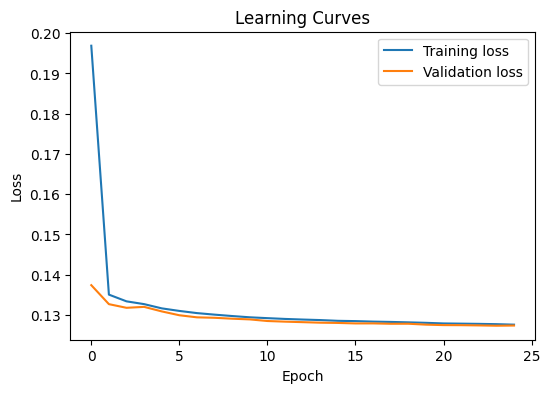

Saved: images/compare_grid.png


ValueError: continuous format is not supported

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

xlim, ylim = (-2.0, 1.0), (-1.5, 1.5)

X = build_multiscale_dataset(
    n_points=1000000,
    xlim=xlim,
    ylim=ylim,
    zoom_scale_range=(0.01, 1.0),  # from 1% to full window
    p_global=0.3,
    max_iter=1000,
)

y = np.array(
    [escape_fraction(x, y, max_iter=200) for x, y in X],
    dtype=np.float32
)


# Stratified split
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42, shuffle=True
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, stratify=y_tmp, random_state=42, shuffle=True
)

# Model
model = NeuralNetFourierFeatures(num_hidden_layers=4)

# Train
model = train(
    model, X_train, y_train, X_val, y_val,
    num_epoch=25, batch_size=2048, lr=1e-3,
    visualize=True, visualize_epochs=5, save_checkpoints=True
)

# Build GT mask once (vectorized)
# Same xlim/ylim/res as used for plots
xlim, ylim, res = (-2,1), (-1.5,1.5), (400,400)
X2d, Y2d, gt_mask = mandelbrot_grid_dataset(nx=res[0], ny=res[1], xlim=xlim, ylim=ylim, max_iter=1000)

# Get model probabilities on the same grid
X, Y, grid = make_grid(xlim, ylim, res)
prob = model_prob_grid(model, device, grid, res)

# Save comparison grid
compare_grid(gt_mask, prob, threshold=0.5, xlim=xlim, ylim=ylim,
             outpath="images/compare_grid.png")


# Test
report = test(model, X_test, y_test, threshold=0.5)
print("\nReport:", report)

In [15]:
# Save model
os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), "models/fourier_mlp_final.pt")


In [ ]:
checkpoint_paths = [f"images/checkpoints/{f}" for f in os.listdir('images/checkpoints')]

build_model_fn = lambda: NeuralNetFourierFeatures(num_hidden_layers=4)
save_animation(checkpoint_paths, build_model_fn, device,
               xlim=(-2,1), ylim=(-1.5,1.5), res=(400,400),
               outpath="images/training.gif")


### Visual Tests


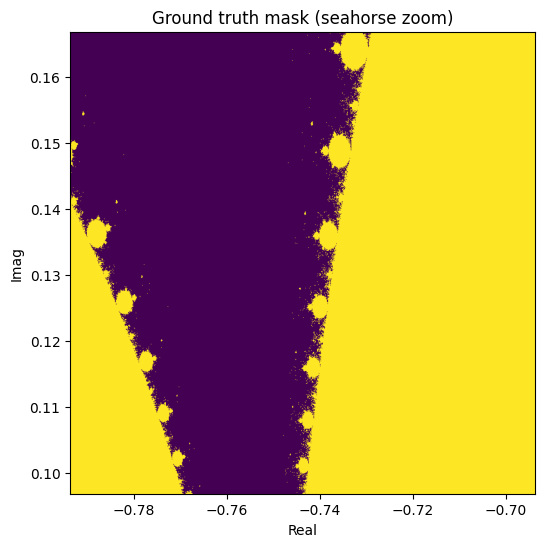

In [50]:
center = (-0.743643887037151, 0.131825904205330)  # seahorse valley
initial_width, initial_height = 1.0, 0.7
z = 0.1

width = initial_width * z
height = initial_height * z

x_center, y_center = center
xlim = (x_center - width / 2, x_center + width / 2)
ylim = (y_center - height / 2, y_center + height / 2)

# GT mask at this zoom
X_gt, Y_gt, gt_mask = mandelbrot_grid_dataset(
    nx=800, ny=800, xlim=xlim, ylim=ylim, max_iter=1000
)

plt.figure(figsize=(6, 6))
plt.imshow(gt_mask, extent=[*xlim, *ylim], origin="lower", aspect="auto")
plt.xlabel("Real"); plt.ylabel("Imag")
plt.title("Ground truth mask (seahorse zoom)")
plt.show()


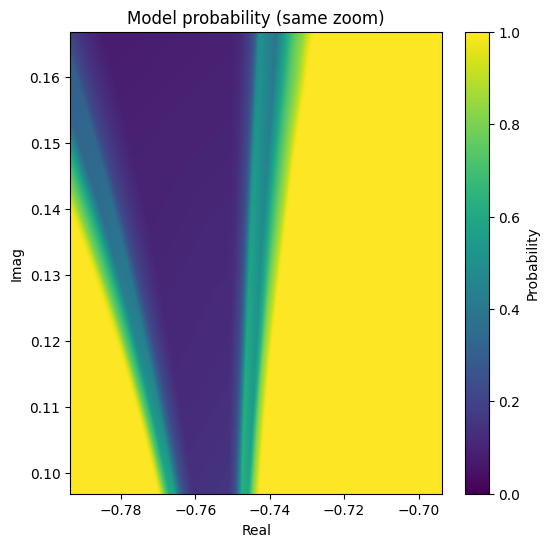

In [51]:
model.eval()
Xg, Yg, grid = make_grid(xlim, ylim, res=(800, 800))
prob = model_prob_grid(model, device, grid, res=(800, 800))

plt.figure(figsize=(6, 6))
plt.imshow(prob, extent=[*xlim, *ylim], origin="lower", aspect="auto",
           interpolation="lanczos", vmin=0.0, vmax=1.0)
plt.colorbar(label="Probability")
plt.xlabel("Real"); plt.ylabel("Imag")
plt.title("Model probability (same zoom)")
plt.show()
